In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline
from sklearn.decomposition import PCA

# PyTorch імпорти
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler
from torch.nn import functional as F

# Класичні моделі
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
import xgboost as xgb

In [2]:
# Налаштування для відтворюваності
torch.manual_seed(42)
np.random.seed(42)
sns.set_style('whitegrid')

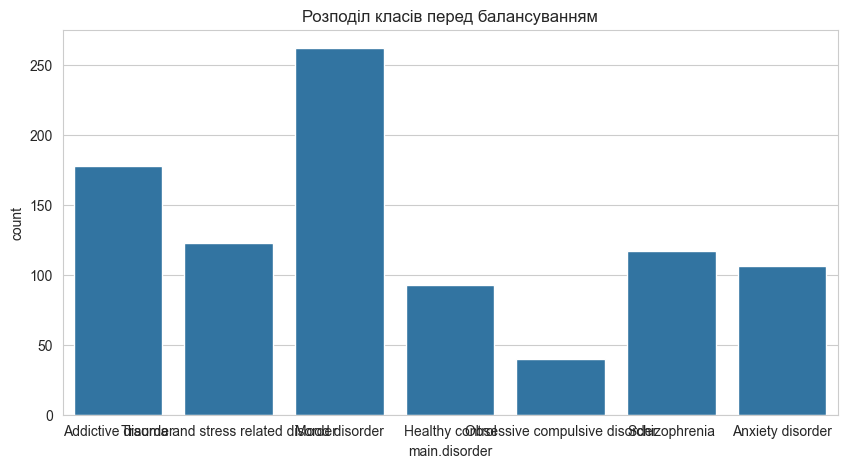

In [3]:
# 1. Завантаження та попередня обробка даних
df = pd.read_csv('data/EEG.machinelearing_data_BRMH.csv')

# Видалення непотрібних стовпців
df = df.drop(columns=['no.', 'eeg.date', 'Unnamed: 122'], errors='ignore')

df = df.dropna()

# Аналіз розподілу класів
plt.figure(figsize=(10, 5))
sns.countplot(x=df['main.disorder'])
plt.title('Розподіл класів перед балансуванням')
plt.show()

# Кодування міток
label_encoder = LabelEncoder()
df['main.disorder'] = label_encoder.fit_transform(df['main.disorder'])
target = 'main.disorder'

# Вибір ознак
X = df.select_dtypes(include=[np.number]).drop(columns=[target]).values
y = df[target].values

C:\Users\valik\.conda\envs\RLP\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\valik\.conda\envs\RLP\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\valik\.conda\envs\RLP\Lib\subprocess.py", line 550, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\valik\.conda\envs\RLP\Lib\subprocess.py", line 1028, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\valik\.conda\envs\RLP\Lib\subprocess.py", line 1540, in _execute_child
    hp, ht

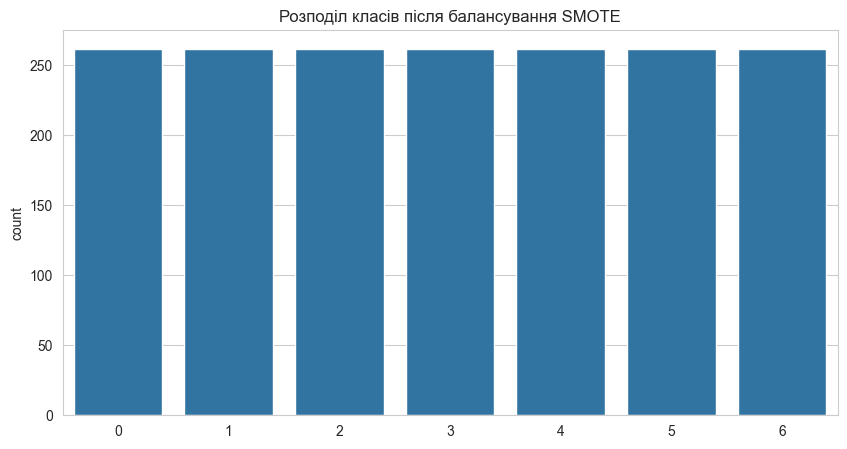

In [4]:
# 2. Обробка дисбалансу класів
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

# Візуалізація після балансування
plt.figure(figsize=(10, 5))
sns.countplot(x=y_res)
plt.title('Розподіл класів після балансування SMOTE')
plt.show()

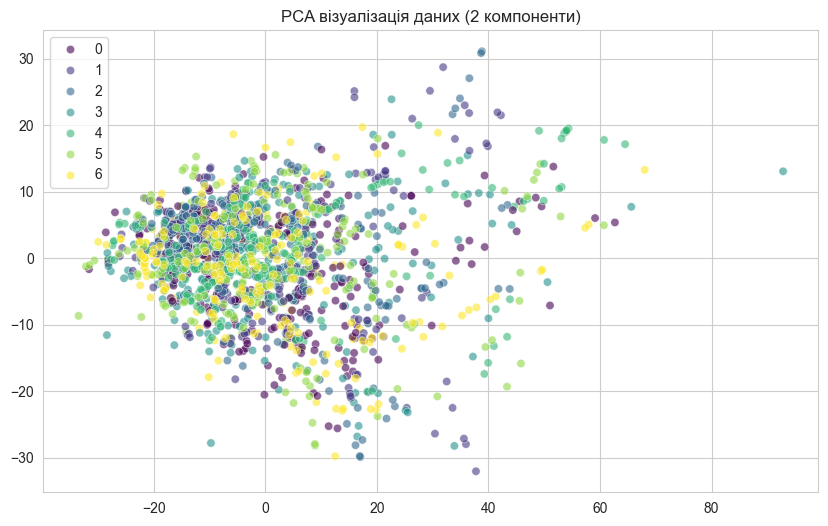

Кількість компонент після PCA: 90


In [5]:
# 3. Масштабування та PCA
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X_res)

# PCA для візуалізації
pca_vis = PCA(n_components=2)
X_pca_vis = pca_vis.fit_transform(X_scaled)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca_vis[:, 0], y=X_pca_vis[:, 1], hue=y_res, palette='viridis', alpha=0.6)
plt.title('PCA візуалізація даних (2 компоненти)')
plt.show()

# PCA для зменшення розмірності (зберігаємо 95% дисперсії)
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)
print(f"Кількість компонент після PCA: {X_pca.shape[1]}")

In [6]:
# 4. Розділення даних
X_train, X_test, y_train, y_test = train_test_split(
    X_pca, y_res, test_size=0.2, random_state=42, stratify=y_res
)

In [7]:
# 5. Класичні моделі з оптимізацією гіперпараметрів
def evaluate_model(model, name, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    print(f"\n--- {name} ---")
    print(classification_report(y_test, y_pred))
    print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")

    return {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1': f1
    }


In [8]:
# SVM з пошуком по сітці
param_grid_svm = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}
grid_svm = GridSearchCV(SVC(probability=True), param_grid_svm, cv=5, n_jobs=-1)
svm_metrics = evaluate_model(grid_svm, "SVM (optimized)", X_train, y_train, X_test, y_test)

# Random Forest з вагами класів
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}
grid_rf = GridSearchCV(
    RandomForestClassifier(class_weight='balanced'),
    param_grid_rf, cv=5, n_jobs=-1
)
rf_metrics = evaluate_model(grid_rf, "Random Forest (optimized)", X_train, y_train, X_test, y_test)

# XGBoost з вагами класів
xgb_model = xgb.XGBClassifier(
    use_label_encoder=False,
    eval_metric='mlogloss',
    scale_pos_weight=len(y_train[y_train == 0])/len(y_train[y_train == 1])
)
xgb_metrics = evaluate_model(xgb_model, "XGBoost", X_train, y_train, X_test, y_test)

KeyboardInterrupt: 

In [13]:
try:
    # Спроба створити ансамбль з оптимальними моделями
    ensemble = VotingClassifier(estimators=[
        ('svm', grid_svm.best_estimator_),
        ('rf', grid_rf.best_estimator_),
        ('xgb', xgb_model)
    ], voting='soft', n_jobs=-1)

    # Оцінка ансамблю
    ensemble_metrics = evaluate_model(ensemble, "Ensemble Model", X_train, y_train, X_test, y_test)

except Exception as e:
    print(f"Помилка при створенні ансамблю: {e}")
    print("Спробуємо альтернативний підхід...")

    # Альтернативний варіант - простий ансамбль без VotingClassifier
    from sklearn.base import clone

    # Навчання моделей окремо
    models = {
        'svm': clone(grid_svm.best_estimator_).fit(X_train, y_train),
        'rf': clone(grid_rf.best_estimator_).fit(X_train, y_train),
        'xgb': clone(xgb_model).fit(X_train, y_train)
    }

    # Отримання передбачень ймовірностей
    proba_svm = models['svm'].predict_proba(X_test)
    proba_rf = models['rf'].predict_proba(X_test)
    proba_xgb = models['xgb'].predict_proba(X_test)

    # Усереднення ймовірностей
    avg_proba = (proba_svm + proba_rf + proba_xgb) / 3
    y_pred = np.argmax(avg_proba, axis=1)

    # Розрахунок метрик
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    print("\n--- Ensemble Model (Alternative) ---")
    print(classification_report(y_test, y_pred))
    print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")

    ensemble_metrics = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1': f1
    }

Помилка при створенні ансамблю: 'super' object has no attribute '__sklearn_tags__'
Спробуємо альтернативний підхід...


C:\Users\valik\.conda\envs\RLP\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:40:05] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



--- Ensemble Model (Alternative) ---
              precision    recall  f1-score   support

           0       0.63      0.79      0.70        52
           1       0.81      0.90      0.85        52
           2       0.87      0.90      0.89        52
           3       0.49      0.40      0.44        53
           4       0.94      0.96      0.95        53
           5       0.84      0.79      0.81        52
           6       0.89      0.74      0.80        53

    accuracy                           0.78       367
   macro avg       0.78      0.78      0.78       367
weighted avg       0.78      0.78      0.78       367

Accuracy: 0.7820, Precision: 0.7810, Recall: 0.7820, F1: 0.7780


In [14]:
# 6. Побудова нейромережі з PyTorch
class EEGNet(nn.Module):
    def __init__(self, input_size, num_classes):
        super(EEGNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

In [15]:
# Підготовка даних для PyTorch
X_train_tensor = torch.FloatTensor(X_train)
X_test_tensor = torch.FloatTensor(X_test)
y_train_tensor = torch.LongTensor(y_train)
y_test_tensor = torch.LongTensor(y_test)

# Ваги класів для WeightedRandomSampler
class_counts = np.bincount(y_train)
class_weights = 1. / torch.Tensor(class_counts)
sample_weights = class_weights[y_train]

sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

In [28]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Ініціалізація моделі
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = EEGNet(input_size=X_train.shape[1], num_classes=len(np.unique(y_res))).to(device)

# Функція втрат з вагами класів
class_weights_tensor = torch.FloatTensor(class_weights).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.1)

In [29]:
# Навчання моделі
def train_model(model, train_loader, criterion, optimizer, epochs=50):
    model.train()
    train_losses = []

    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = correct / total
        scheduler.step(epoch_loss)
        train_losses.append(epoch_loss)

        if (epoch + 1) % 5 == 0:
            print(f'Epoch {epoch+1}/{epochs} - Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')

    return train_losses

In [30]:
train_losses = train_model(model, train_loader, criterion, optimizer, epochs=1000)

Epoch 5/1000 - Loss: 1.4416, Accuracy: 0.4833
Epoch 10/1000 - Loss: 0.9726, Accuracy: 0.6728
Epoch 15/1000 - Loss: 0.7702, Accuracy: 0.7287
Epoch 20/1000 - Loss: 0.5773, Accuracy: 0.8016
Epoch 25/1000 - Loss: 0.4793, Accuracy: 0.8316
Epoch 30/1000 - Loss: 0.3831, Accuracy: 0.8773
Epoch 35/1000 - Loss: 0.3230, Accuracy: 0.8930
Epoch 40/1000 - Loss: 0.2654, Accuracy: 0.9087
Epoch 45/1000 - Loss: 0.2464, Accuracy: 0.9080
Epoch 50/1000 - Loss: 0.2327, Accuracy: 0.9243
Epoch 55/1000 - Loss: 0.1920, Accuracy: 0.9434
Epoch 60/1000 - Loss: 0.1528, Accuracy: 0.9496
Epoch 65/1000 - Loss: 0.1693, Accuracy: 0.9427
Epoch 70/1000 - Loss: 0.1382, Accuracy: 0.9564
Epoch 75/1000 - Loss: 0.1103, Accuracy: 0.9639
Epoch 80/1000 - Loss: 0.1227, Accuracy: 0.9605
Epoch 85/1000 - Loss: 0.1125, Accuracy: 0.9611
Epoch 90/1000 - Loss: 0.1145, Accuracy: 0.9598
Epoch 95/1000 - Loss: 0.0939, Accuracy: 0.9727
Epoch 100/1000 - Loss: 0.1011, Accuracy: 0.9659
Epoch 105/1000 - Loss: 0.1363, Accuracy: 0.9550
Epoch 110/10

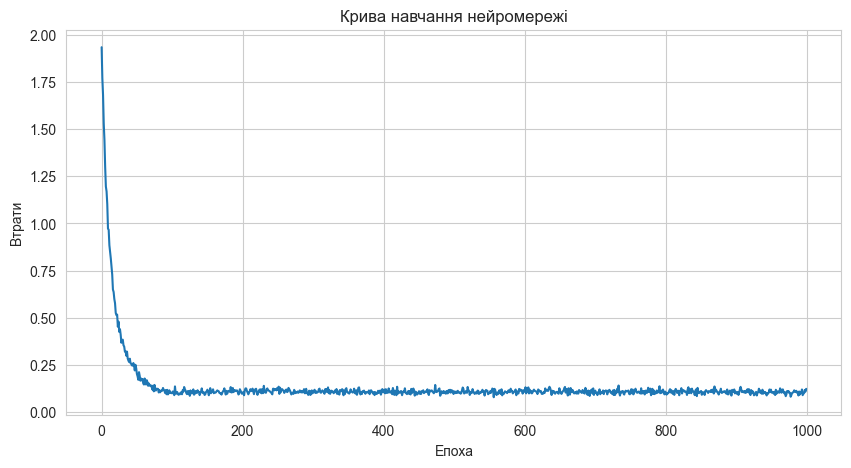

In [31]:
# Візуалізація втрат
plt.figure(figsize=(10, 5))
plt.plot(train_losses)
plt.title('Крива навчання нейромережі')
plt.xlabel('Епоха')
plt.ylabel('Втрати')
plt.show()

In [32]:
# Оцінка нейромережі
def evaluate_pytorch_model(model, test_loader):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            y_true.extend(labels.numpy())
            y_pred.extend(predicted.cpu().numpy())

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    print("\n--- PyTorch Neural Network ---")
    print(classification_report(y_true, y_pred))
    print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")

    return {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1': f1
    }

In [33]:
nn_metrics = evaluate_pytorch_model(model, test_loader)


--- PyTorch Neural Network ---
              precision    recall  f1-score   support

           0       0.63      0.73      0.68        52
           1       0.74      0.92      0.82        52
           2       0.84      0.94      0.89        52
           3       0.53      0.34      0.41        53
           4       0.91      0.92      0.92        53
           5       0.83      0.75      0.79        52
           6       0.80      0.74      0.76        53

    accuracy                           0.76       367
   macro avg       0.75      0.76      0.75       367
weighted avg       0.75      0.76      0.75       367

Accuracy: 0.7629, Precision: 0.7541, Recall: 0.7629, F1: 0.7527


In [34]:
# 7. Порівняння всіх моделей
results = pd.DataFrame({
    'SVM': svm_metrics,
    'Random Forest': rf_metrics,
    'XGBoost': xgb_metrics,
    'Ensemble': ensemble_metrics,
    'Neural Network': nn_metrics
})


<Figure size 1500x600 with 0 Axes>

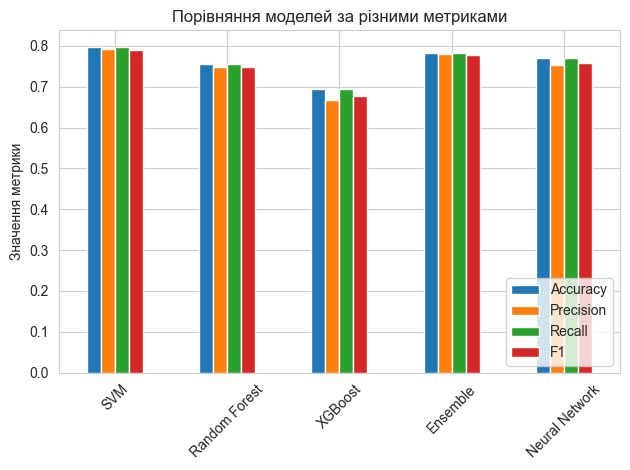

In [23]:
# Візуалізація результатів
plt.figure(figsize=(15, 6))
results.T.plot(kind='bar', rot=45)
plt.title('Порівняння моделей за різними метриками')
plt.ylabel('Значення метрики')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

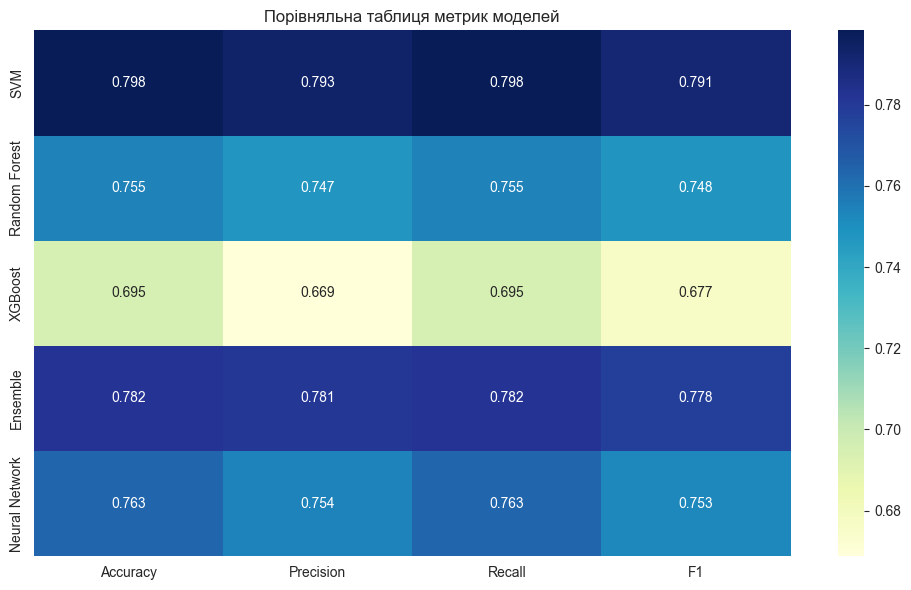

In [35]:

# Теплова карта результатів
plt.figure(figsize=(10, 6))
sns.heatmap(results.T, annot=True, cmap='YlGnBu', fmt='.3f')
plt.title('Порівняльна таблиця метрик моделей')
plt.tight_layout()
plt.show()

In [36]:
import joblib
import torch

# 1. Визначимо всі моделі та їх метрики
all_models = {
    'SVM': (grid_svm.best_estimator_, svm_metrics['Accuracy']),
    'Random Forest': (grid_rf.best_estimator_, rf_metrics['Accuracy']),
    'XGBoost': (xgb_model, xgb_metrics['Accuracy']),
    'Ensemble': (ensemble, ensemble_metrics['Accuracy']),
    'Neural Network': (model, nn_metrics['Accuracy'])  # PyTorch модель
}

# 2. Знайдемо модель з найвищою точністю
best_model_name = max(all_models.items(), key=lambda x: x[1][1])[0]
best_model, best_accuracy = all_models[best_model_name]

print(f"\nНайкраща модель: {best_model_name} з точністю {best_accuracy:.4f}")

# 3. Збереження моделі в залежності від типу
if best_model_name == 'Neural Network':
    # Збереження PyTorch моделі
    torch.save({
        'model_state_dict': best_model.state_dict(),
        'input_size': X_train.shape[1],
        'num_classes': len(np.unique(y_res)),
        'scaler': scaler,
        'pca': pca,
        'label_encoder': label_encoder
    }, 'best_eeg_model.pth')
    print("Збережено PyTorch модель у файлі 'best_eeg_model.pth'")
else:
    # Збереження sklearn-сумісних моделей
    joblib.dump({
        'model': best_model,
        'scaler': scaler,
        'pca': pca,
        'label_encoder': label_encoder
    }, 'best_eeg_model.joblib')
    print("Збережено модель у файлі 'best_eeg_model.joblib'")

# 4. Додатково: збереження всіх метрик для подальшого аналізу
results.to_csv('model_metrics_comparison.csv')
print("Збережено метрики всіх моделей у 'model_metrics_comparison.csv'")


Найкраща модель: SVM з точністю 0.7984
Збережено модель у файлі 'best_eeg_model.joblib'
Збережено метрики всіх моделей у 'model_metrics_comparison.csv'


In [9]:
df

,sex,age,education,IQ,main.disorder,specific.disorder,AB.A.delta.a.FP1,AB.A.delta.b.FP2,AB.A.delta.c.F7,AB.A.delta.d.F3,...,COH.F.gamma.o.Pz.p.P4,COH.F.gamma.o.Pz.q.T6,COH.F.gamma.o.Pz.r.O1,COH.F.gamma.o.Pz.s.O2,COH.F.gamma.p.P4.q.T6,COH.F.gamma.p.P4.r.O1,COH.F.gamma.p.P4.s.O2,COH.F.gamma.q.T6.r.O1,COH.F.gamma.q.T6.s.O2,COH.F.gamma.r.O1.s.O2
1,M,37.0,6.0,120.0,0,Alcohol use disorder,13.425118,11.002916,11.942516,15.272216,...,45.595619,17.510824,26.777368,28.201062,57.108861,32.375401,60.351749,13.900981,57.831848,43.463261
2,M,32.0,16.0,113.0,0,Alcohol use disorder,29.941780,27.544684,17.150159,23.608960,...,99.475453,70.654171,39.131547,69.920996,71.063644,38.534505,69.908764,27.180532,64.803155,31.485799
3,M,35.0,18.0,126.0,0,Alcohol use disorder,21.496226,21.846832,17.364316,13.833701,...,59.986561,63.822201,36.478254,47.117006,84.658376,24.724096,50.299349,35.319695,79.822944,41.141873
4,M,36.0,16.0,112.0,0,Alcohol use disorder,37.775667,33.607679,21.865556,21.771413,...,61.462720,59.166097,51.465531,58.635415,80.685608,62.138436,75.888749,61.003944,87.455509,70.531662
5,F,24.0,14.0,105.0,0,Alcohol use disorder,13.482096,14.095855,12.854630,11.727480,...,92.841723,82.302355,83.938567,88.213886,90.972026,77.443894,89.545596,72.579530,89.462863,86.127823
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
940,M,22.0,13.0,116.0,2,Healthy control,41.851823,36.771496,43.671792,36.860889,...,82.905657,34.850706,63.970519,63.982003,51.244725,62.203684,62.062237,31.013031,31.183413,98.325230
941,M,26.0,13.0,118.0,2,Healthy control,18.986856,19.401387,27.586436,20.194732,...,65.917918,66.700117,44.756285,49.787513,98.905995,54.021304,93.902401,52.740396,92.807331,56.320868
942,M,26.0,16.0,113.0,2,Healthy control,28.781317,32.369230,11.717778,23.134370,...,61.040959,27.632209,45.552852,33.638817,46.690983,19.382928,41.050717,7.045821,41.962451,19.092111
943,M,24.0,13.0,107.0,2,Healthy control,19.929100,25.196375,14.445391,16.453456,...,99.113664,48.328934,41.248470,28.192238,48.665743,42.007147,28.735945,27.176500,27.529522,20.028446


In [10]:
df.describe()

,age,education,IQ,main.disorder,AB.A.delta.a.FP1,AB.A.delta.b.FP2,AB.A.delta.c.F7,AB.A.delta.d.F3,AB.A.delta.e.Fz,AB.A.delta.f.F4,...,COH.F.gamma.o.Pz.p.P4,COH.F.gamma.o.Pz.q.T6,COH.F.gamma.o.Pz.r.O1,COH.F.gamma.o.Pz.s.O2,COH.F.gamma.p.P4.q.T6,COH.F.gamma.p.P4.r.O1,COH.F.gamma.p.P4.s.O2,COH.F.gamma.q.T6.r.O1,COH.F.gamma.q.T6.s.O2,COH.F.gamma.r.O1.s.O2
count,919.000000,919.000000,919.000000,919.000000,919.000000,919.000000,919.000000,919.000000,919.000000,919.000000,...,919.000000,919.000000,919.000000,919.000000,919.000000,919.000000,919.000000,919.000000,919.000000,919.000000
mean,30.631850,13.443961,101.520131,2.786725,20.220673,21.238662,17.842093,18.925629,20.451592,19.505537,...,75.895626,55.057672,56.880152,60.622141,69.889681,47.782752,66.750528,39.235988,66.094264,56.933558
std,11.801693,2.556308,17.031157,2.005493,11.372461,12.348722,10.084667,9.134357,9.807305,9.295489,...,15.815383,19.505953,18.225074,18.060825,17.704717,19.566560,17.047160,20.675547,18.100158,19.516664
min,18.000000,0.000000,49.000000,0.000000,3.272260,3.244199,3.050507,3.412618,5.066593,4.048931,...,12.611954,0.519048,6.926792,0.708008,2.421748,0.036664,1.032207,1.228502,0.363268,3.988805
25%,21.805000,12.000000,91.000000,1.000000,12.812690,13.032435,11.157449,12.464049,13.531989,12.690113,...,68.049966,41.641266,43.701438,48.362521,59.001486,32.604240,55.862451,22.104332,54.695239,43.908411
50%,26.170000,13.000000,102.000000,3.000000,17.036455,17.776402,15.571381,16.634008,18.022553,17.432568,...,78.647712,55.296428,56.541607,61.160337,72.393403,45.695172,68.238375,36.549938,67.985045,57.256823
75%,35.495000,16.000000,114.000000,5.000000,24.446362,25.899411,21.773978,23.331895,25.679216,23.952932,...,87.328315,69.724576,70.538246,73.954954,83.214723,61.896512,79.134352,54.112441,79.501972,71.333099
max,71.880000,20.000000,145.000000,6.000000,92.826192,101.515687,91.373456,82.544167,101.566662,77.197502,...,99.678649,100.000000,99.307895,100.000000,99.581629,98.720067,99.650154,98.413320,100.000000,99.287092


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 919 entries, 1 to 944
Columns: 1146 entries, sex to COH.F.gamma.r.O1.s.O2
dtypes: float64(1143), int64(1), object(2)
memory usage: 8.0+ MB


In [16]:
import os
import joblib
def test_random_samples(model, df, scaler, pca, label_encoder, num_samples=5):
    """
    Тестує випадкові записи з датасету на моделі

    Параметри:
    model - навчена модель
    df - вихідний DataFrame
    scaler - об'єкт масштабування
    pca - об'єкт PCA
    label_encoder - кодувальник міток
    num_samples - кількість випадкових записів для тестування
    """
    # Вибір випадкових записів
    random_indices = np.random.choice(df.index, size=num_samples, replace=False)
    test_samples = df.iloc[random_indices]

    # Виділення ознак (виключаємо цільову змінну та нечислові стовпці)
    features = test_samples.select_dtypes(include=[np.number]).drop(columns=['main.disorder'], errors='ignore')

    # Отримання справжніх міток
    true_labels = test_samples['main.disorder']
    true_labels_decoded = label_encoder.inverse_transform(true_labels)

    # Передобробка даних
    X_scaled = scaler.transform(features)
    X_pca = pca.transform(X_scaled)

    # Прогнозування
    if isinstance(model, nn.Module):  # Для PyTorch моделі
        model.eval()
        with torch.no_grad():
            inputs = torch.FloatTensor(X_pca).to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            predicted_labels = predicted.cpu().numpy()
    else:  # Для sklearn моделей
        predicted_labels = model.predict(X_pca)

    # Декодування міток
    predicted_labels_decoded = label_encoder.inverse_transform(predicted_labels)

    # Виведення результатів
    print(f"{'Індекс':<10}{'Справжній клас':<20}{'Прогнозований клас':<20}{'Вірно?':<10}")
    print("-" * 60)

    correct = 0
    for idx, true, pred in zip(random_indices, true_labels_decoded, predicted_labels_decoded):
        is_correct = true == pred
        if is_correct:
            correct += 1
        print(f"{idx:<10}{true:<20}{pred:<20}{str(is_correct):<10}")

    accuracy = correct / num_samples
    print("\nТочність на вибірці:", accuracy)

    return random_indices, true_labels_decoded, predicted_labels_decoded

# Приклад використання:
if 'best_eeg_model.joblib' in os.listdir():
    model_data = joblib.load('best_eeg_model.joblib')
    test_random_samples(
        model=model_data['model'],
        df=df,
        scaler=model_data['scaler'],
        pca=model_data['pca'],
        label_encoder=model_data['label_encoder']
    )
elif 'best_eeg_model.pth' in os.listdir():
    checkpoint = torch.load('best_eeg_model.pth')
    model = EEGNet(checkpoint['input_size'], checkpoint['num_classes'])
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    test_random_samples(
        model=model,
        df=df,
        scaler=checkpoint['scaler'],
        pca=checkpoint['pca'],
        label_encoder=checkpoint['label_encoder']
    )
else:
    print("Модель не знайдена. Спочатку навчіть та збережіть модель.")

Індекс    Справжній клас      Прогнозований клас  Вірно?    
------------------------------------------------------------
181       Healthy control     Healthy control     True      
734       Obsessive compulsive disorderObsessive compulsive disorderTrue      
673       Mood disorder       Mood disorder       True      
862       Schizophrenia       Schizophrenia       True      
517       Anxiety disorder    Anxiety disorder    True      

Точність на вибірці: 1.0


C:\Users\valik\.conda\envs\RLP\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but RobustScaler was fitted without feature names
  warnings.warn(


In [20]:
# Витягуємо один рядок, наприклад перший (індекс 0)
single_row = df.iloc[[120]]  # подвійні дужки, щоб зберегти його як DataFrame

# Зберігаємо у CSV
single_row.to_csv('single_row.csv', index=False)


In [21]:
single_row

,sex,age,education,IQ,main.disorder,specific.disorder,AB.A.delta.a.FP1,AB.A.delta.b.FP2,AB.A.delta.c.F7,AB.A.delta.d.F3,...,COH.F.gamma.o.Pz.p.P4,COH.F.gamma.o.Pz.q.T6,COH.F.gamma.o.Pz.r.O1,COH.F.gamma.o.Pz.s.O2,COH.F.gamma.p.P4.q.T6,COH.F.gamma.p.P4.r.O1,COH.F.gamma.p.P4.s.O2,COH.F.gamma.q.T6.r.O1,COH.F.gamma.q.T6.s.O2,COH.F.gamma.r.O1.s.O2
130,F,29.86,20.0,113.0,2,Healthy control,46.306229,47.379694,48.808082,50.943346,...,90.988675,82.588144,91.86914,88.146513,82.027254,87.799612,85.360432,84.867957,90.909785,90.73056
